In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import callbacks as cb
import os, json, math, librosa
import IPython.display as ipd
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00010.wav


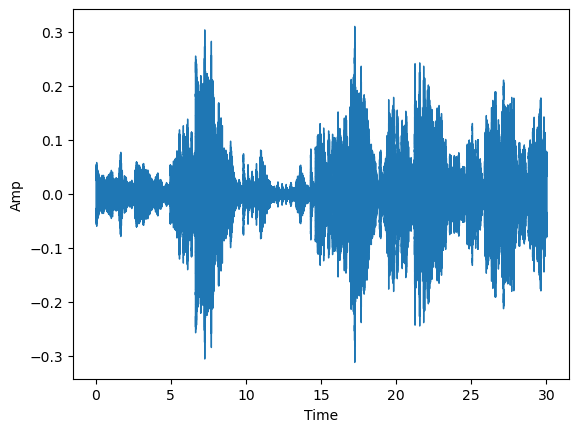

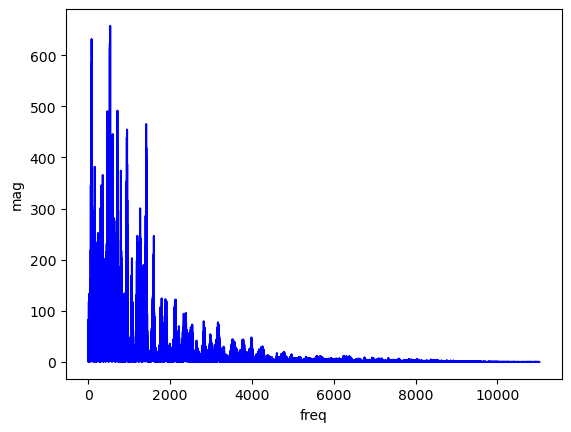

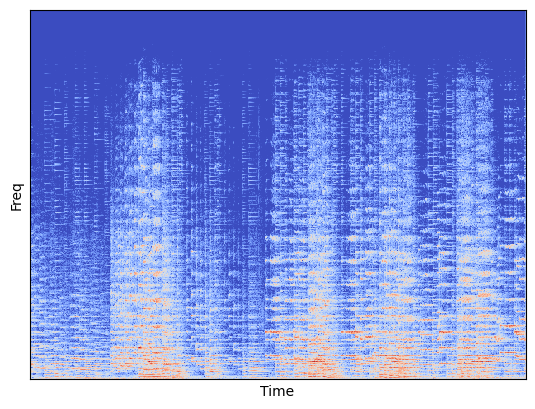

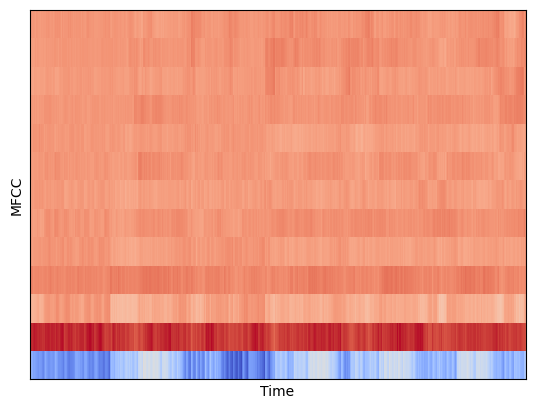

In [2]:
file = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00010.wav"
print(file)


# waveform
signal, sr = librosa.load(file, sr=22050)
dis.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amp")
plt.show()


# fft -> spectrum
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_freq = frequency[: int(len(frequency) / 2)]
left_mag = magnitude[: int(len(magnitude) / 2)]

plt.plot(left_freq, left_mag, color="b")
plt.xlabel("freq")
plt.ylabel("mag")
plt.show()


# fft
n_fft = 2048  # window when considering performing a single fft
hop_length = 512  # amount shifting after each transform

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Freq")
plt.show()


# mfcc
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.show()


In [3]:
# Getting Genres from folder name

MUSIC = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/'
music_dataset = [] # File locations for each wav file 
genre_target = [] # 
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/data/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[5])
            

In [4]:
print("genres in dataset: ", set(genre_target))

genres in dataset:  {'metal', 'reggae', 'jazz', 'country', 'hiphop', 'pop', 'disco', 'blues', 'rock', 'classical'}


In [5]:
audio_path = music_dataset[500]

x , sr = librosa.load(audio_path)
librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)



In [6]:
# Visualizing Audio File as a waveform
plt.figure(figsize=(16, 5))
# librosa.display.waveplot(x, sr=sr)

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

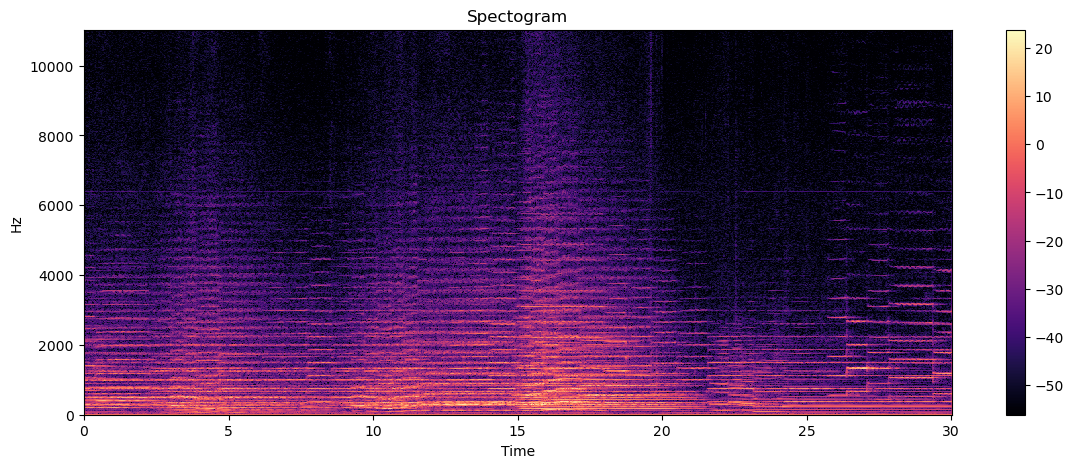

In [7]:
# Visualizing audio file as a spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()

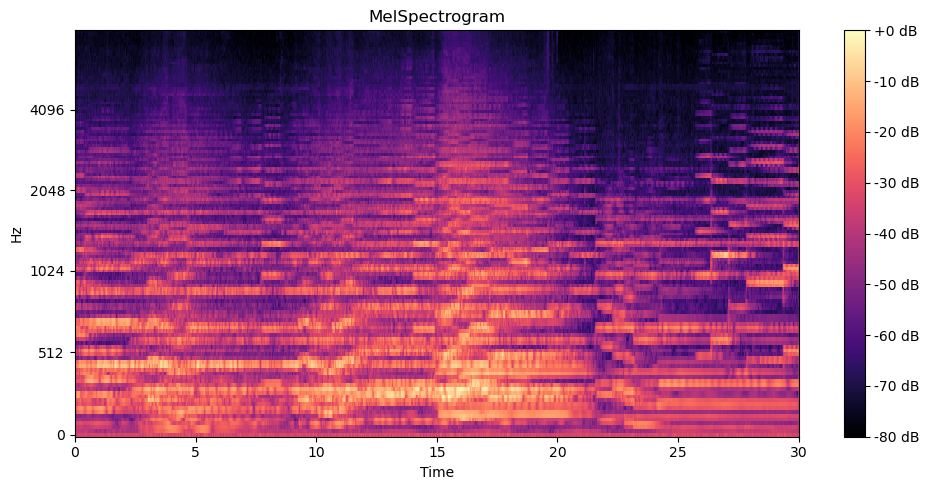

In [8]:
file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()


In [9]:
DATASET_PATH = '../input/gtzan-dataset-music-genre-classification/Data/genres_original/'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                if file_path != '../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav':
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=15)
print("process finished")


Processing: disco

Processing: metal

Processing: reggae

Processing: blues

Processing: rock

Processing: classical

Processing: jazz

Processing: hiphop

Processing: country

Processing: pop
process finished


In [10]:
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# # folder_path = '/kaggle/working/callbacks'
# remove_folder_contents(folder_path)

In [11]:
DATA_PATH = "./data_10.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    X, y, z = load_data(DATA_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = True,random_state =42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=1, shuffle = True, random_state = 42)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape):
#      input_shape=(-1, 87, 13, 1)
    model = Sequential()
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape = input_shape),
    keras.layers.BatchNormalization(),
#    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

    return model


def predict(model, X, y):
    
    X = X[np.newaxis, ...]
    print("heo",X.shape)
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [12]:
# os.mkdir('callbacks')
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.1, 0)
# X_train = np.reshape(X_train,(-1,87,13,1))
# print(X_train.shape)

In [13]:
# get train, validation, test splits
print(X_train.shape)
# create network
input_shape = (X_train.shape[1],X_train.shape[2],1)
model = build_model(input_shape)

# # compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0025)
model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath = "/kaggle/working/callbacks",
    monitor = "val_loss",
    mode = "min"
)]
model.summary()

(13477, 87, 13, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 1, 96)         11712     
                                                                 
 batch_normalization (BatchN  (None, 20, 1, 96)        384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 1, 256)        614656    
                                                                 
 batch_normalization_1 (Batc  (None, 20, 1, 256)       1024      
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 1, 384)        885120    
                                                                 
 batch_normalization_2 (Batc  (None

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.97,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

In [18]:
import os
import time
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

Epoch 1/20
27/27 [==============================] - 151s 6s/step - loss: 1.5297 - accuracy: 0.4482 - val_loss: 19.6226 - val_accuracy: 0.1822
Epoch 2/20
27/27 [==============================] - 146s 5s/step - loss: 1.4296 - accuracy: 0.4862 - val_loss: 10.4263 - val_accuracy: 0.2196
Epoch 3/20
27/27 [==============================] - 152s 6s/step - loss: 1.3631 - accuracy: 0.5144 - val_loss: 3.2203 - val_accuracy: 0.2717
Epoch 4/20
27/27 [==============================] - 148s 6s/step - loss: 1.3143 - accuracy: 0.5360 - val_loss: 1.9029 - val_accuracy: 0.3959
Epoch 5/20
27/27 [==============================] - 154s 6s/step - loss: 1.2517 - accuracy: 0.5636 - val_loss: 1.6461 - val_accuracy: 0.4493
Epoch 6/20
27/27 [==============================] - 164s 6s/step - loss: 1.1956 - accuracy: 0.5827 - val_loss: 1.5751 - val_accuracy: 0.4606
Epoch 7/20
27/27 [==============================] - 155s 6s/step - loss: 1.1594 - accuracy: 0.6018 - val_loss: 1.2401 - val_accuracy: 0.5601
Epoch 8/20


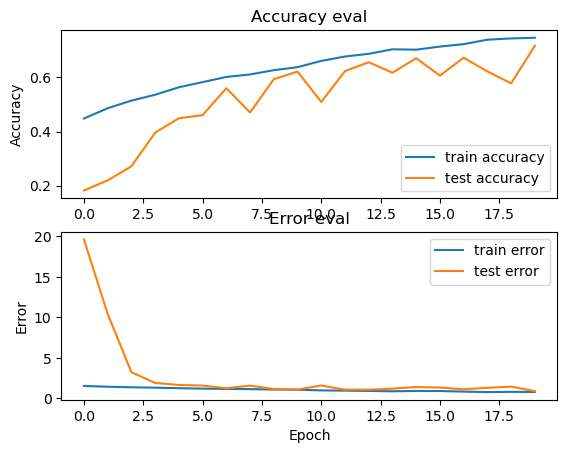

47/47 - 4s - loss: 0.8764 - accuracy: 0.7170 - 4s/epoch - 80ms/step

Test accuracy: 0.7169559597969055


In [19]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=512, epochs=20, verbose = 1, callbacks =my_callbacks)
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [20]:
# pick a sample to predict from the test set
X_to_predict = X_test[165]
y_to_predict = y_test[165]
# predict sample
print(predict(model, X_to_predict, y_to_predict))

heo (1, 87, 13, 1)
1/1 [==============================] - 0s 238ms/step
Target: classical, Predicted label: ['classical']
None


In [21]:
model.evaluate(X_test, y_test)

47/47 [==============================] - 4s 82ms/step - loss: 0.8764 - accuracy: 0.7170


[0.8764164447784424, 0.7169559597969055]

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.876 and val_acc = 0.717


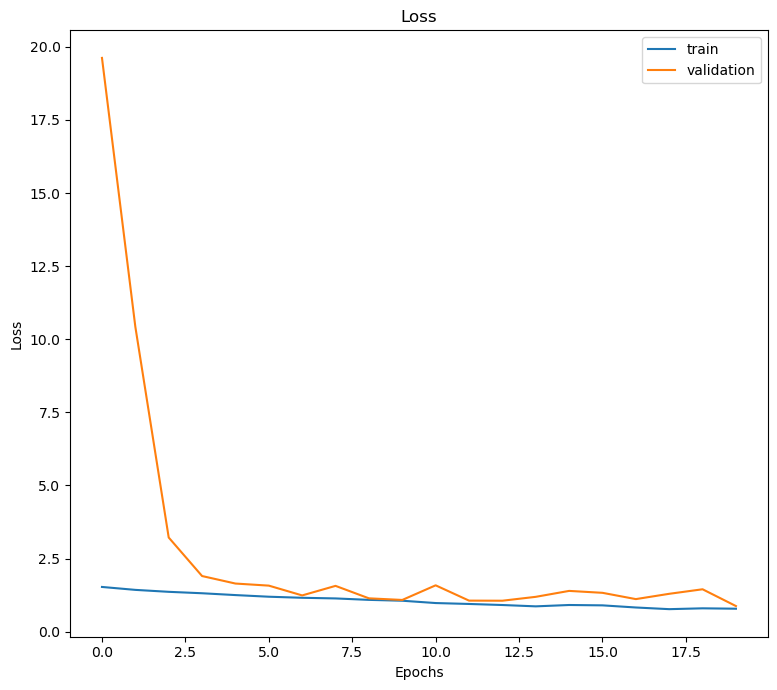

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

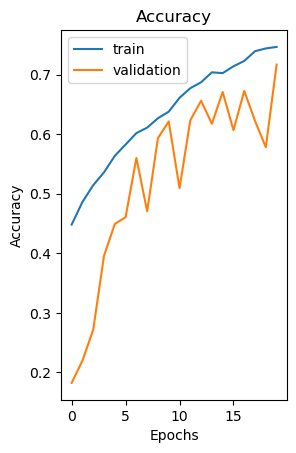

In [24]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [25]:
pred = model.predict(X_train)


422/422 [==============================] - 37s 88ms/step


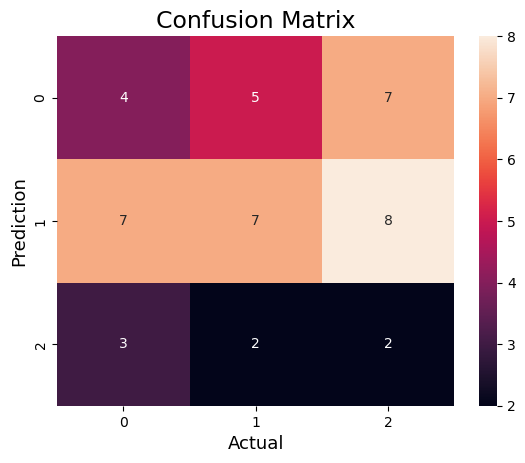


Test accuracy: 0.7169559597969055


In [89]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred)

# Plot the confusion matrix.
sns.heatmap(cm,
            annot=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
  
# Calculate accuracy
print('\nTest accuracy:', test_acc)

In [96]:
class_names = os.listdir(DATASET_PATH)
print(class_names)

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


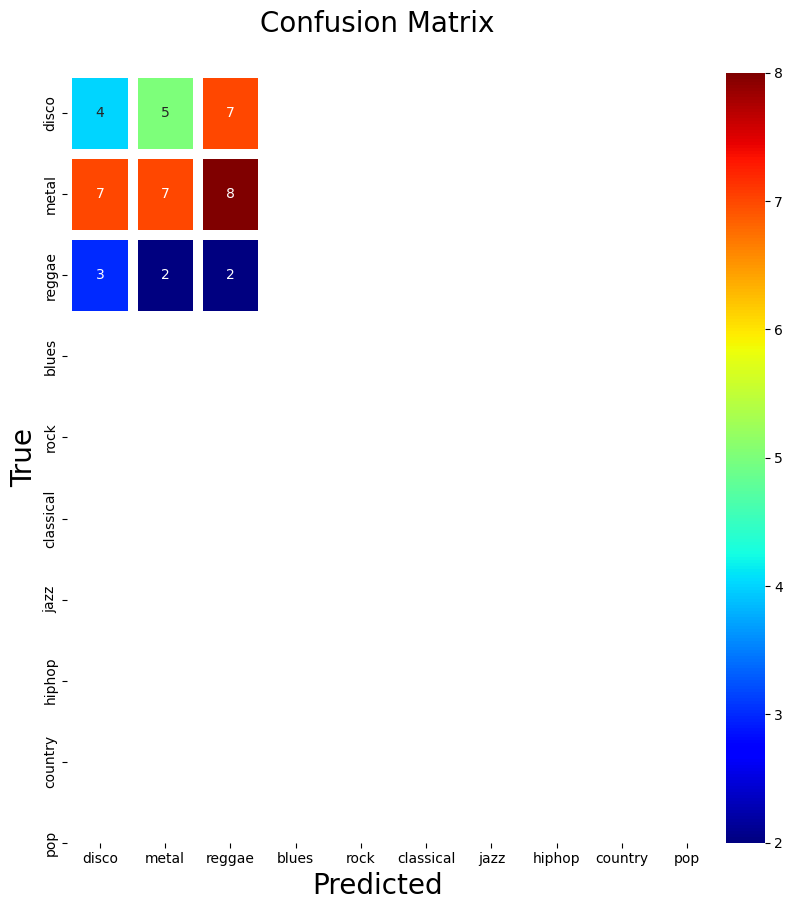

In [115]:
plt.figure(figsize=(10,10))
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=class_names,
            yticklabels=class_names,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()